In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os
import dlib
import imutils
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/cv_data/data_word.zip' -d '/content'

In [ ]:
#function to get the image sequences from the given path
#'face': face images or whole original images
def extract_data_path(path = './data' , words_or_phrases = 'words' , face=False):
    X_image_seq = []
    y_class = []
    person_ids = [x for x in os.listdir(path) if x[-3:] != 'txt']
    counter = 0
    
    for p_id in person_ids:
        if p_id=='.ipynb_checkpoints':
          continue

        word_or_phrase_type_path = path + '/' + p_id + '/' + words_or_phrases        
        word_or_phrase_ids = os.listdir(word_or_phrase_type_path)
        
        for w_p_id in word_or_phrase_ids:
            word_or_phrase_instance_path = word_or_phrase_type_path + '/' + w_p_id
            instance_ids =  os.listdir(word_or_phrase_instance_path)
            
            for i_id in instance_ids:
                images = os.listdir(word_or_phrase_instance_path + '/' + i_id)

                if face:
                  color_images = [x for x in images if x[-8:-4] == 'face']
                else:
                  color_images = [x for x in images if x[-8:-4] != 'face']

                image_seq = []
                for c_image in color_images:
                    c_image_path = word_or_phrase_instance_path + '/' + i_id + '/' + c_image                    
                    
                    current_image = cv2.imread(c_image_path)
                    image_seq.append(current_image)
                    #image_seq.append(c_image_path)
                    
                X_image_seq.append(image_seq)
                y_class.append(int(w_p_id)-1)

                if (counter+1) % 20 == 0:
                  print("Iteration: " + str(1+counter))
                counter += 1
        
    return X_image_seq, y_class

Iteration: 1


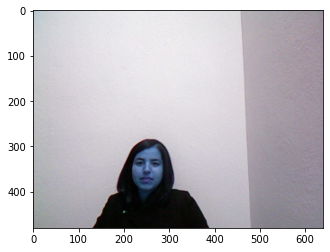

(480, 640, 3)


In [ ]:
X, y = extract_data_path(path='./data_word/')
plt.imshow(X[0][0])
plt.show()
print(X[0][0].shape)

In [ ]:
#function to crop the regions of faces from the whole image
def extract_face(img):
  detector = dlib.get_frontal_face_detector()
  face_rects = detector(img, 0)
  for d in face_rects:
    x1 = d.left()
    y1 = d.top()
    x2 = d.right()
    y2 = d.bottom()
  img_face = img[y1:y2,x1:x2]
  img_face = imutils.resize(img_face, width=72)
  return img_face

In [ ]:
#crop faces from the entire image for all image sequences
def extract_data_face(path = './data' , words_or_phrases = 'words'):
    person_ids = [x for x in os.listdir(path) if x[-3:] != 'txt']
    counter = 0
    
    for p_id in person_ids:
        if p_id=='.ipynb_checkpoints':
          continue

        word_or_phrase_type_path = path + '/' + p_id + '/' + words_or_phrases        
        word_or_phrase_ids = os.listdir(word_or_phrase_type_path)
        
        for w_p_id in word_or_phrase_ids:
            word_or_phrase_instance_path = word_or_phrase_type_path + '/' + w_p_id
            instance_ids =  os.listdir(word_or_phrase_instance_path)
            
            for i_id in instance_ids:
                images = os.listdir(word_or_phrase_instance_path + '/' + i_id)
                color_images = [x for x in images if x[:5] == 'color']
                
                image_seq = []
                for c_image in color_images:
                    c_image_path = word_or_phrase_instance_path + '/' + i_id + '/' + c_image                    
                    
                    current_image = cv2.imread(c_image_path)
                    face_image = extract_face(current_image)

                    face_image_path = c_image_path[:-4] + '_face.jpg'
                    cv2.imwrite(face_image_path, face_image)
                
                if (counter+1) % 20 == 0:
                  print("Iteration: " + str(1+counter))

                counter += 1

        
    return None 

In [ ]:
extract_data_face(path='./data_word')

Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 100
Iteration: 120
Iteration: 140
Iteration: 160
Iteration: 180
Iteration: 200
Iteration: 220
Iteration: 240
Iteration: 260
Iteration: 280
Iteration: 300
Iteration: 320
Iteration: 340
Iteration: 360
Iteration: 380
Iteration: 400
Iteration: 420
Iteration: 440
Iteration: 460
Iteration: 480
Iteration: 500


In [ ]:
#read cropped face images
X_face, y = extract_data_path(path='./data_word', face=True)

In [ ]:
#trimming or padding of image sequences
def data_padding(X, data_len = 15):
    for i, img_seq in enumerate(X):        
        if len(img_seq) < data_len:
            pad_img = img_seq[len(img_seq)-1]
            n = data_len-len(img_seq)
            X[i].extend([pad_img]*n)
        elif len(img_seq) > data_len:
            X[i] = X[i][:data_len]           
    return X

In [ ]:
#data augmentation for the face images
def data_aug_flip(img):
  return cv2.flip(img, 1)

def data_aug_brightness(img, low=0.5, high=2):

  value = random.uniform(low, high)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  img = np.array(img, dtype = np.float64)
  img[:,:,1] = img[:,:,1]*value
  img[:,:,1][img[:,:,1]>255] = 255
  img[:,:,2] = img[:,:,2]*value
  img[:,:,2][img[:,:,2]>255] = 255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
  return img

def data_aug_channel_shift(img, value=60):
  value = int(random.uniform(-value, value))
  img = img + value
  img[:,:,:][img[:,:,:]>255]  = 255
  img[:,:,:][img[:,:,:]<0]  = 0
  img = img.astype(np.uint8)
  return img

In [ ]:
X_face_aug_flip = []
for img_seq in X_face:
  seq = []
  for img in img_seq:
    seq.append(data_aug_flip(img))
  X_face_aug_flip.append(seq)

X_face_aug_brightness = []
for img_seq in X_face:
  seq = []
  for img in img_seq:
    seq.append(data_aug_brightness(img))
  X_face_aug_brightness.append(seq)

X_face_aug_channel_shift = []
for img_seq in X_face:
  seq = []
  for img in img_seq:
    seq.append(data_aug_channel_shift(img))
  X_face_aug_channel_shift.append(seq)

y_aug_flip = y[:]
y_aug_brightness = y[:]
y_aug_channel_shift = y[:]